<a href="https://colab.research.google.com/github/sagnikbiswas/Google_OR_Tools_Notebooks/blob/main/VRP_PD.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Vehicle Routing with Pickups and Deliveries

A vehicle routing problem (VRP) with pickups and deliveries is an optimization problem where a number of vehicles, starting from a depot, have to make deliveries from a pickup location to a delivery location and return to the depot. The goal is to minimize the longest route taken by any vehicle, or in other words, minimize the time taken to complete all deliveries.

Following is a demonstration for a proof of concept of solving VRP with pickups and deliveries using Google OR-Tools.


In [1]:
!pip install --upgrade ortools

from ortools.constraint_solver import pywrapcp
from ortools.constraint_solver import routing_enums_pb2

import matplotlib.pyplot as plt
import numpy as np

##Inputs

In [2]:
# Coordinates of all locations
coords = [(456, 320), # location 0 - the depot
    (228, 0),    # location 1
    (912, 0),    # location 2
    (0, 80),     # location 3
    (114, 80),   # location 4
    (570, 160),  # location 5
    (798, 160),  # location 6
    (342, 240),  # location 7
    (684, 240),  # location 8
    (570, 400),  # location 9
    (912, 400),  # location 10
    (114, 480),  # location 11
    (228, 480),  # location 12
    (342, 560),  # location 13
    (684, 560),  # location 14
    (0, 640),    # location 15
    (798, 640)]  # location 16

# Number of vehicles
num_vehicles = 4

# Pickup and delivery location indices
pickups_deliveries = [
    [1, 6],
    [2, 10],
    [4, 3],
    [5, 9],
    [7, 8],
    [15, 11],
    [13, 12],
    [16, 14],
]

# Depot/start and end location index
depot = 0

This is what the problem looks like. Arrow tails denote the pickup and the heads denote the delivery locations.

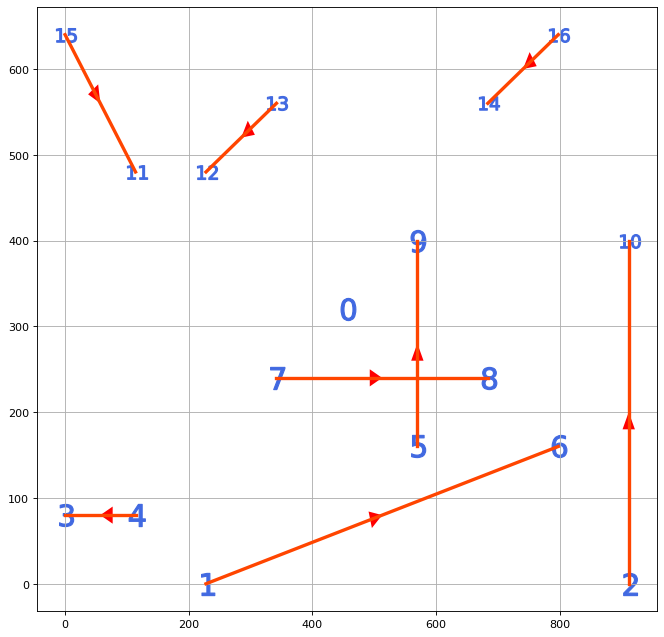

In [3]:
fig, ax = plt.subplots(figsize=(10,10), dpi = 80)

for i in range(len(coords)):
    ax.scatter(coords[i][0], coords[i][1], marker=f'${i}$', s=400, c='royalblue')

for p1, p2 in pickups_deliveries:

    line_xs = [coords[p1][0], coords[p2][0]]
    line_ys = [coords[p1][1], coords[p2][1]]
    ax.plot(line_xs, line_ys, linewidth = 3, color='orangered')

    arrow_x, arrow_y = coords[p1]
    arrow_dx, arrow_dy = (coords[p2][0]-arrow_x)//2, (coords[p2][1]-arrow_y)//2
    ax.arrow(arrow_x, arrow_y, arrow_dx, arrow_dy, color='red', linewidth = 0, head_width = 20, head_length = 20, length_includes_head = True)

ax.grid()
plt.show()

##Creating the data model

We will need to compute the distances between all pairs of locations first.

In [4]:
# creating distance matrix from list of coordinates

def create_distance_matrix(coordinates, distance='euclidean'):

    if distance == 'euclidean':
        def dist_2d_eucledian(point1, point2):
            return ((point1[0]-point2[0])**2 + (point1[1]-point2[1])**2)**(0.5)

        distance_matrix = []
        for loc in coordinates:
            temp = []
            for next_loc in coordinates:
                temp.append(int(dist_2d_eucledian(loc, next_loc)))
            distance_matrix.append(temp)


    if distance == 'manhattan':
        def dist_2d_manhattan(point1, point2):
            return abs(point1[0]-point2[0]) + abs(point1[1] - point2[1])

        distance_matrix = []
        for loc in coordinates:
            temp = []
            for next_loc in coordinates:
                temp.append(int(dist_2d_manhattan(loc, next_loc)))
            distance_matrix.append(temp)

    return distance_matrix


In [5]:
# We will use Manhattan distance
distance_matrix = create_distance_matrix(coords, distance='manhattan')

In [6]:
# Create data model
data = {
    'distance_matrix': distance_matrix,
    'num_vehicles': num_vehicles,
    'pickups_deliveries': pickups_deliveries,
    'depot': depot
}

In [7]:
# RoutingIndexManager manages the conversion between nodes in our data to indices within the routing solver
manager = pywrapcp.RoutingIndexManager(len(data['distance_matrix']), data['num_vehicles'], data['depot'])
routing = pywrapcp.RoutingModel(manager)

We define a distance callback, which in this example simply returns the manhattan distances between two nodes stored in our data model

In [8]:
def distance_callback(from_index, to_index):
    from_node = manager.IndexToNode(from_index)
    to_node = manager.IndexToNode(to_index)
    return data['distance_matrix'][from_node][to_node]

transit_callback_index = routing.RegisterTransitCallback(distance_callback)

In [9]:
#Arc cost is the length of an arc between a pair of nodes
routing.SetArcCostEvaluatorOfAllVehicles(transit_callback_index)

A `dimension` computes the cumulative distance traveled by each vehicle along its route.

In [10]:
routing.AddDimension(transit_callback_index, 0, 3000, True, 'Distance')
distance_dimension = routing.GetDimensionOrDie('Distance')

In the following cell, `SetGlobalSpanCostCoefficient` sets a large penalty to the maximums of different vehicles. Here this will give us an objective value of `100 * max_i(Dist_i) + sum_i Dist_i` where `Dist_i` is the distance traveled by vehicle i, and 100 is the penalty. Due tot the penalty, the maximum distance will dominate the objective function and thus the optimizer will try to minimize it.

In [11]:
distance_dimension.SetGlobalSpanCostCoefficient(100)

Defining the pickup and delivery locations.

In [12]:
for p, d in data['pickups_deliveries']:
    pickup_index = manager.NodeToIndex(p)
    delivery_index = manager.NodeToIndex(d)
    routing.AddPickupAndDelivery(pickup_index, delivery_index)

    # The same vehicle should do the pickup and corresponding delivery
    routing.solver().Add(routing.VehicleVar(pickup_index) == routing.VehicleVar(delivery_index))
    # The pickup must happen before the delivery, i.e., cumulative distance during pickup must be less thn or equal to that during delivery
    routing.solver().Add(distance_dimension.CumulVar(pickup_index) <= distance_dimension.CumulVar(delivery_index))

## Solution

Initial solution strategy using `PARALLEL_CHEAPEST_INSERTION` which iteratively inserts cheapest node at cheapest position.

In [13]:
search_parameters = pywrapcp.DefaultRoutingSearchParameters()
search_parameters.first_solution_strategy = routing_enums_pb2.FirstSolutionStrategy.PARALLEL_CHEAPEST_INSERTION

Optional metaheuristic (Gives a better result)

In [14]:
# Tabu search is metaheuristic search strategy which generally works well for VRP
#search_parameters = pywrapcp.DefaultRoutingSearchParameters()
search_parameters.local_search_metaheuristic = routing_enums_pb2.LocalSearchMetaheuristic.TABU_SEARCH
search_parameters.time_limit.seconds = 10

In [15]:
solution = routing.SolveWithParameters(search_parameters)

## Printing the solution

In [21]:
def print_solution(data, manager, routing, solution):
    print(f'Objective: {solution.ObjectiveValue()}')
    total_distance = 0
    max_route_distance = 0
    for vehicle_id in range(data['num_vehicles']):
        index = routing.Start(vehicle_id)
        plan_output = f'Route for vehicle {vehicle_id}:\n'
        route_distance = 0
        while not routing.IsEnd(index):
            plan_output += f' {manager.IndexToNode(index)} -> '
            previous_index = index
            index = solution.Value(routing.NextVar(index))
            route_distance += routing.GetArcCostForVehicle(previous_index, index, vehicle_id)
        max_route_distance = max(max_route_distance, route_distance)    
        plan_output += f'{manager.IndexToNode(index)}\n'
        plan_output += f'Distance of the route: {route_distance}m\n'
        print(plan_output)
        total_distance += route_distance
    print(f'longest route among all vehicles: {max_route_distance}m\n')
    print(f'Total Distance of all routes: {total_distance}m')


In [22]:
if solution:
    print_solution(data, manager, routing, solution)

Objective: 210504
Route for vehicle 0:
 0 ->  16 ->  14 ->  13 ->  12 -> 0
Distance of the route: 1780m

Route for vehicle 1:
 0 ->  5 ->  2 ->  10 ->  9 -> 0
Distance of the route: 1712m

Route for vehicle 2:
 0 ->  4 ->  3 ->  15 ->  11 -> 0
Distance of the route: 2032m

Route for vehicle 3:
 0 ->  7 ->  1 ->  6 ->  8 -> 0
Distance of the route: 1780m

longest route among all vehicles: 2032m

Total Distance of all routes: 7304m


## Plotting the solution

First we store the solution routes in a list

In [18]:
def store_routes_in_list(data, manager, routing, solution):
    routes = []
    for v_id in range(data['num_vehicles']):
        temp = []
        index = routing.Start(v_id)
        while not routing.IsEnd(index):
            temp.append(manager.IndexToNode(index))
            previous_index = index
            index = solution.Value(routing.NextVar(index))
        temp.append(manager.IndexToNode(index))
        routes.append(temp)
    return routes

In [19]:
solution_routes = store_routes_in_list(data, manager, routing, solution)

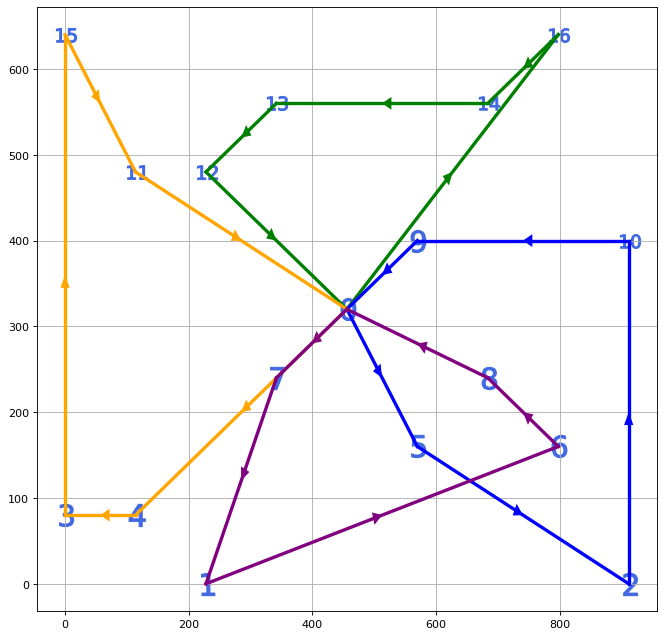

In [20]:
fig, ax = plt.subplots(figsize=(10,10), dpi = 80)

for i in range(len(coords)):
    ax.scatter(coords[i][0], coords[i][1], marker=f'${i}$', s=400, c='royalblue')

route_colors = ['green', 'blue', 'orange', 'purple', 'lime', 'brown', 'pink', 'olive', 'skyblue', 'grey'] * (data['num_vehicles']//10 + 1)

for route_num in range(len(solution_routes)):
    for i in range(len(solution_routes[route_num])-1):
        tail_node = coords[solution_routes[route_num][i]]
        head_node = coords[solution_routes[route_num][i+1]]

        x, y = tail_node
        dx, dy = (head_node[0] - tail_node[0])//2, (head_node[1] - tail_node[1])//2

        ax.plot([head_node[0], tail_node[0]], [head_node[1], tail_node[1]], lw = 3, c=route_colors[route_num])
        ax.arrow(x,y,dx,dy,color=route_colors[route_num], lw = 0, head_width = 15, head_length = 15, length_includes_head = True)

ax.grid()
plt.show()

This concludes the demonstration